In [6]:
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

In [2]:
# load the Swiss Glacier Inventory 2016
sgi = gpd.read_file('data/sgi_2016/SGI_2016_glaciers.shp')

### 1. Investigate the dataset and answer the following questions
1) What datatype did you just load?
2) How many glaciers are contained in the dataset?
3) How many attributes does the dataset have and which ones?
4) What are the datatypes of the individual columns?
5) Which is the largest glacier, which one is the smallest glacier?
6) How many glaciers have a name?

Try using the attributes & functions gdf.shape, gdf.columns, gdf.dtypes, gdf.idxmin() and others to do this. Replace the three dots with the right commands. 

In [ ]:
sgi.head()

In [ ]:
# what datatype is the data you just loaded?
type(...)

In [ ]:
# how many rows and colums does it have?
sgi. ... #number of (rows, colums)

In [ ]:
# what attributes does it have?
sgi. ...

In [4]:
# What are the datatypes of the different attributes?
sgi. ... #datatypes

gid            float64
pk_glacier      object
sgi-id          object
name            object
rl_0            object
rl_1             int64
rl_2             int64
rl_3            object
i_code          object
year_acq         int64
year_rel         int64
area_km2       float64
length_km      float64
masl_min         int64
masl_med         int64
masl_mean        int64
masl_max         int64
slope_deg      float64
aspect_deg       int64
geometry      geometry
dtype: object

In [ ]:
# How is the geometry stored as a whole?
type(sgi. ...)

In [ ]:
# What do these geometries look like, and what datatype are they?
# How is the geometry stored as a whole?
print(...)
print(type(...[0]))

In [ ]:
# Which glacier is largest, which one smallest?
max_area_id = sgi[...].idxmin()
sgi.loc[max_area_id]

In [ ]:
# How many glaciers don't have a name? 
sgi[...].isnull().sum() 
# How would you set up your query to find the number of glaciers that do have a name?


### 2. Let's look at the spatial part in a bit more detail

Select one glacier and investigate it's geometry in more detail answering the following questions:

1) What datatype does the geometry have / how is it stored?
2) Explore the geometry's attributes length, area, centroid and bounds. What can you learn?
3) What coordinate reference system is the dataset in?
4) What happens if you query length, area etc. on the whole SGI?

In [ ]:
# Make a new variable that contains the geometry of only one glacier of your choice. 
myglacier = sgi[sgi[...]==...] # use name or sgi-id to select a glacier 

In [ ]:
myglacier.length #How is this length different from the length stored in the sgi dataset?

In [ ]:
myglacier. ... #What is the coordinate reference system (crs)?

In [ ]:
sgi. ... # Query (e.g., the centroid) of the whole sgi. What do you get?

### 3. Plotting

1) Use sgi.plot() to plot the Swiss Glacier Inventory. Ok, nice, but not particularly useful (yet). 
2) Zoom in (set x and y limits) on the area around Silvretta glacier.
3) Find the right bounds for the chloropleth map that shows a good category for the different glacier areas.

In [ ]:
# Function to format tick marks in km rather than m
def meters_to_kilometers(x, pos):
    """Convert meters to kilometers."""
    return f'{x / 1e3:.0f}'

<Axes: >

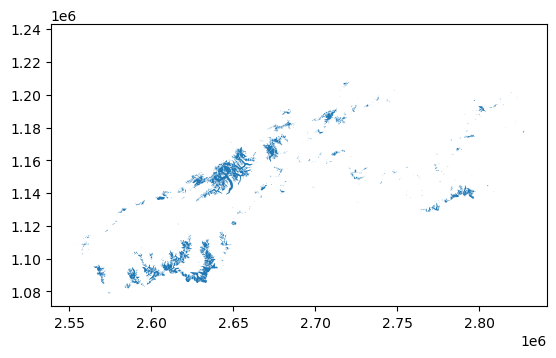

In [4]:
sgi.plot()

Text(0.5, 1.0, 'Silvretta-region glacier areas')

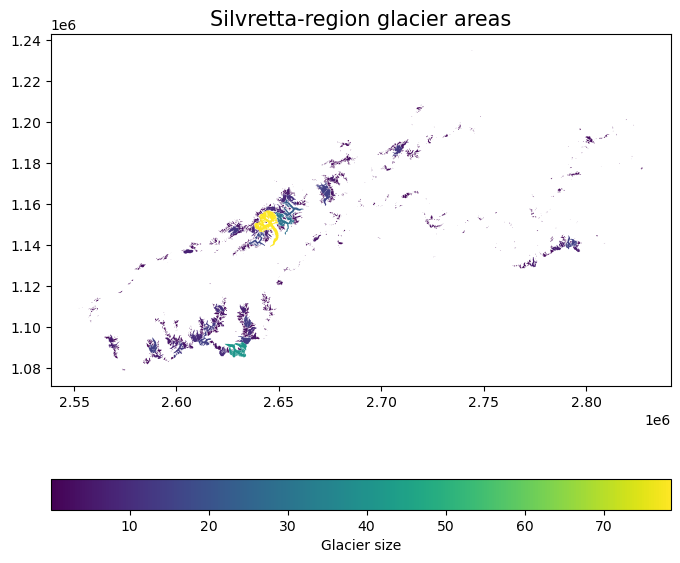

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
sgi.plot(ax=ax, 
         column='area_km2', 
         #vmin=..., 
         #vmax=..., 
         legend=True,
         legend_kwds={"label": "Glacier size", "orientation": "horizontal"})
# Create custom formatters for the x and y axis
x_formatter = FuncFormatter(meters_to_kilometers)
y_formatter = FuncFormatter(meters_to_kilometers)

# Apply the formatters to the axes for pretty labels
ax.xaxis.set_major_formatter(x_formatter)
ax.yaxis.set_major_formatter(y_formatter)

#ax.set_xlim([..., ...])
#ax.set_ylim([..., ...])
ax.set_title('Silvretta-region glacier areas', fontsize=15)

When you like your result, save it as a pdf. PDF is a useful format because it can be imported into vector editing programs (Adobe Illustrator, Affinity Designer, Inkscape...) for final editing. 


In [5]:
#fig.savefig('Silvretta_glaciers.pdf')

### 4. Filtering spatially

1) Find all glaciers withing the Silvretta region (use the bounding box you defined above)
2) Find all glaciers that are in 

In [ ]:
# Example bounding box coordinates (use the ones you defined above)
minx, miny, maxx, maxy = [..., ..., ..., ...]  # Replace with your bounding box coordinates

In [ ]:
# Create a bounding box
silvretta_region = box(minx, miny, maxx, maxy)

In [ ]:
silvretta_glaciers = sgi[sgi.geometry.within(silvretta_region)]

In [ ]:
# Find all glaciers that are in southern Switzerland (e.g., below y<1 130 000)
southern = sgi.cx[ : , : ...].plot() 

In [ ]:
# Now adapt this for eastern, western or northern Switzerland
... = sgi.cx[ : , : ].plot() 

### 5. Some typical geometric operations

Geopandas offers functionality for typical geometric operations such as smoothing or buffering. Check the documentation to see what arguments [geopandas.GeoSeries.simplify](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.simplify.html) and
[geopandas.GeoSeries.buffer()](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoSeries.buffer.html) take.

Create 
1) a simplified version of your glacier outline and plot both the original and smoothed version
2) create a buffer around your glacier and plot both the buffered and the original outlines

In [ ]:
# smooth
silvretta_smoothed = sgi[sgi.name=='Silvrettagletscher'].geometry.simplify(...)

In [ ]:
f, ax = plt.subplots()
silvretta_smoothed.plot(ax=ax, facecolor='none', edgecolor='k')
sgi[sgi.name=='Silvrettagletscher'].geometry.plot(ax=ax, facecolor='none', edgecolor='red')

In [ ]:
# buffer
silvretta_buffered = sgi[sgi.name=='Silvrettagletscher'].geometry.buffer(...)

In [ ]:
f, ax = plt.subplots()
silvretta_buffered.plot(ax=ax, facecolor='none', edgecolor='k')
sgi[sgi.name=='Silvrettagletscher'].geometry.plot(ax=ax, facecolor='none', edgecolor='red')

### 6. Reading and writing spatial data with pandas and geopandas

We want to be able to query our spatial datasets at defined locations! 
Create and save a shape file that contains three sampling points within Silvretta glacier by follwoing these steps:
1) define points
2) turn the points into a python dictionary and use the shapely Point() function to turn your points into shaply geometry objects.
3) turn your dictionary into a Pandas GeoDataFrame
4) save the gdf to file using "GeoJSON" as the driver.
5) inspect the file you just saved in using a text editor. What advantages do you see in comparison to the traditional .shp files?
6) Let's also save the outline of Silvretta glacier.
7) Want to sample randomly? Investigate the function geopandas.GeoSeries.sample_points()

In [ ]:
# create geojson file with points of interest for sampling
point1 = ..., ...
point2 = ..., ...
point3 = ..., ...

In [ ]:
# turn points into dictionary
sps = {'Points': ['Point1', 'Point2', 'Point3'], 'geometry': [Point(point1), Point(point2), Point(point3)]}
# turn dictionary into GeoDataFrame
sampling_points = gpd.GeoDataFrame(sps, crs=...)

In [ ]:
# Now let's write this to a geojson
sampling_points.to_file('./data/sampling_points.geojson', driver='GeoJSON')

In [ ]:
# Let's also save our outline for re-use in further exercises
silv_outline = sgi[sgi.name=='Silvrettagletscher']
silv_outline.geometry.to_file('./data/silvretta_outline.geojson', driver='GeoJSON')

In [ ]:
# What if you wanted to sample a random set of points within your outline?
rand_points = silv_outline.sample_points(...)
rand_points.plot()

### 7. Let's add some spatial data that is available in tabular form

Load the Glacier Ice Thickness database (glathida) and inspect the dataset.

1) What attributes does it have?
2) What spatial coordinate system do you think this is in? Does the dataset know this already?
3) Go ahead and extract all the ice thickness measurements for Silvrettaglacier into its own variable.
4) Turn the dataframe into a spatially-aware GeoDataFrame that allows you to perform spatial operations and reproject it into the Swiss Coordinate System CH1903+ / LV95 

In [ ]:
# Load ice thickness measurements
glathida = pd.read_csv('data/glathida-3.1.0/data/TTT.csv', low_memory=False)

In [ ]:
#Inspect the dataset

In [ ]:
# Extract the data for Silvretta glacier
silvretta = glathida[glathida.GLACIER_NAME=='SILVRETTA']

In [ ]:
# make into geopandas dataframe
geometry = [Point(xy) for xy in zip(silvretta[...], silvretta[...])] #list-comprehension & zip() iterator on tuples of coordinates
silvretta_gdf = gpd.GeoDataFrame(silvretta, geometry=geometry)

In [ ]:
# explore the crs
print("Current CRS:", silvretta_gdf.crs)

In [ ]:
silvretta_gdf = silvretta_gdf.set_crs(epsg=..., inplace=True)

In [ ]:
# reproject to Swiss Coordinate System LV95
silvretta_lv95 = silvretta_gdf.to_crs(epsg=...)

### 8. Spatial operations operations with point data

We now have two spatial datasets from the same area (glacier outlines and ice thickness measurements). Let's explore how the two can be used together. 

1) Create a new variable that cointains all the ice thickness points that are inside our glacier outline using [gpd.sjoin()](https://geopandas.org/en/stable/docs/reference/api/geopandas.sjoin.html)
2) Plot the outline and all the points, marking the ones that are inside the outline.
3) In a second figure, color the points by their ice thickness values
4) How would you go about ensuring that the points you consider "inside" are at a minimum distance from the outline?

In [ ]:
# Find the points that are inside the polygon
# Step 1: Spatial Join
points_inside = gpd.sjoin(..., ..., predicate=...)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
silvretta_lv95.plot(ax=ax, marker=..., color=..., markersize..., alpha=..., zorder=1)
points_inside.plot(ax=ax, marker=..., color=..., markersize=..., alpha=..., zorder=2)
silv_outline.plot(ax=ax, color='steelblue', zorder=0)
plt.title('Silvretta GPR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# Now lets look at the ice thickness values for the points inside our outline
fig, ax = plt.subplots(figsize=(10, 10))
d = plt.scatter(
    points_inside.geometry.x,  # x-coordinates of points
    points_inside.geometry.y,  # y-coordinates of points
    c=points_inside[...],  # values to use for coloring
    cmap=...,  # colormap
    s=...,  # size of markers
    edgecolor=...,  # edge color of markers
    alpha=...  # transparency
)
silv_outline.plot(ax=ax, edgecolor='k', facecolor='none', zorder=0)
cbar = fig.colorbar(d, ax=ax, label='Thickness', shrink=0.5)
plt.title('Silvretta GPR')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
# using an inside buffer
silv_outline_buffered = ... #buffer inside
silv_outline.loc[:,['buffered']] = silv_outline_buffered #add geometry as new column (could also replace original one)
silv_outline = silv_outline.set_geometry('buffered') #set new column as geometry
silv_outline = silv_outline.drop('geometry', axis=1) # if added as new column, drop old one, otherwise spatial join keeps geomety, which screws up the plotting
points_inside_buff = gpd.sjoin(...) # re-run spatial join
#plot

### 9. Let's interpolate these points 

In [ ]:
# Extract the bounds of the polygon
minx, miny, maxx, maxy = silv_outline.total_bounds
# Create an empty grid for interpolation
grid_x, grid_y = np.mgrid[minx:maxx:100j, miny:maxy:100j]  # 100j for a 100x100 grid

In [ ]:
points = np.array(list(zip(points_inside.geometry.x, points_inside.geometry.y)))
values = points_inside['THICKNESS'].values

In [ ]:
grid_z = griddata(points, values, (grid_x, grid_y), method='linear') #try also cubic. Which one looks better?

In [ ]:
f, ax = plt.subplots()
#using imshow
ax.imshow(grid_z.T, origin='lower', extent=[grid_x.min(), grid_x.max(), grid_y.min(), grid_y.max()], aspect='auto', cmap='Blues')
#using contour
#ax.contourf(grid_x, grid_y, grid_z, cmap='Blues')

#add points from measurements
d = plt.scatter(
    points_inside.geometry.x,  # x-coordinates of points
    points_inside.geometry.y,  # y-coordinates of points
    c=points_inside['THICKNESS'],  # values to use for coloring
    cmap='Blues',  # colormap
    s=50,  # size of markers
    edgecolor='none',  # edge color of markers
    alpha=1  # transparency
)
silv_outline.plot(ax=ax, facecolor='None')